In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from CLEARview import lattice, aperture, elements, opticsUtils, plot
import pandas as pd
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [2]:
from CLEARview import clearST_survey0_tfs #get the lattice

# Relativistic parametres (from the plasmaDefocus using CLEARview)
P0 = 200.0                    #[MeV]
m0c2 = 511e-03                #[MeV]
E0 = np.sqrt(m0c2**2 + P0**2) #[MeV]

# Initial twiss parametres 
N = 200         # Number of particles
epsn_x = 10.0   #[um]
epsn_y = 10.0   #[um]

# Find geometrical emittance
epsg_x = opticsUtils.get_eps_g(epsn_x,E0) 
epsg_y = opticsUtils.get_eps_g(epsn_y,E0) 
print('Geometrical emittance in x =', epsg_x)
print('Geometrical emittance in y =', epsg_y)

# Constraints in Plasma lens
#sigma_PL = 0.2e-03     #[m]
alpha_PL = 0.0

# Initial beta and alpha in the position of the Plasma lens
beta0x = 0.5002
alpha0x = 0.02
beta0y = 0.5002
alpha0y = 0.02

x0 = 0.0  #[mm]
y0 = 0.0  #[1e-3]
xp0 = 0.0 #[mm]
yp0 = 0.0 #[1e-3]

# Twiss matrix for propagating
xt_init = np.asarray([beta0x, alpha0x, opticsUtils.getGamma(alpha0x,beta0x)])
yt_init = np.asarray([beta0y, alpha0y, opticsUtils.getGamma(alpha0y,beta0y)])
print(xt_init)

def lattice(focus,s_star=True):
    # Fix the setup of the quadrupoles
    latticeCLEAR = clearST_survey0_tfs.buildLattice(P0, doFinalize=False)
    sPLE = latticeCLEAR.getElemS('PLE0800M') # Get the position of the middle of the plasmalens
    latticeCLEAR.implicitSeq_removeElem('CA.DHJ0780') # Remove kicker magnet from the setup
    latticeCLEAR.implicitSeq_removeElem('BTV0800') # Remove to avoid overlapping elements when adding PLE
    latticeCLEAR.implicitSeq_removeElem('PLE0800M') # Remove the marker for the plasmalens
    latticeCLEAR.implicitSeq_removeElem('CA.DHJ0840') # Remove kicker magnet from the setup
    latticeCLEAR.implicitSeq_addElem(elements.CLEAR_Q(0.0, P0), 'QFD0860', 16.2625, refer='end', referFrom=None) # Add focusing magnet
    #latticeCLEAR.implicitSeq_addElem(elements.Marker(),'P', 15.007499999999999) #Mark the start of the plasmalens  
    latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Start', 14.400)
    if s_star:
        latticeCLEAR.implicitSeq_addElem(elements.Marker(), 's* = 0', 18.1815)
    #latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Symmetry point', 18.1815)

    # Remove some markers for a simpler setup (easier to read the plot)
    latticeCLEAR.implicitSeq_removeElem('CA.QS0870')
    latticeCLEAR.implicitSeq_removeElem('CA.BPM0890')
    latticeCLEAR.implicitSeq_removeElem('CA.CLEAR$END')
    latticeCLEAR.implicitSeq_removeElem('CA.CLDUMP$START')
    latticeCLEAR.implicitSeq_removeElem('CA.VAW0915')
    latticeCLEAR.implicitSeq_removeElem('CA.ICT0930')
    latticeCLEAR.implicitSeq_removeElem('CLDUMP$END')
    latticeCLEAR.implicitSeq_removeElem('STLINE$END')
    latticeCLEAR.implicitSeq_removeElem('CA.BTV0910') # Fjernet pga jeg får trøbbel med optimeringen 
    #latticeCLEAR.implicitSeq_finalize()

    # Add markers for different focal points
    #latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Focus point', 18.1815) # Dette er fokuspunktet som er symmetrisk
    latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Focus point', focus)
    #latticeCLEAR.implicitSeq_finalize()

    # ADD PLASMALENS
  
    latticeCLEAR.implicitSeq_addElem( elements.CLEAR_PlasmaLens( 20e-3, 0.50, 0.0, P0 ), 'PLE0800', sPLE)

    latticeCLEAR.implicitSeq_finalize()

    latticeCLEAR_PLE = latticeCLEAR.getSubLattice('PLE0800')
    
    return latticeCLEAR_PLE

Geometrical emittance in x = 0.02558261919631073
Geometrical emittance in y = 0.02558261919631073
[0.5002 0.02   2.    ]


In [3]:

def read_excel_to_arrays(filename):
    # Read the Excel file
    xls = pd.ExcelFile(filename)
    
    # Dictionary to hold the arrays for each sheet
    sheet_arrays = {}
    
    # Loop through each sheet name
    for sheet_name in xls.sheet_names:
        # Read the sheet into a DataFrame
        df = pd.read_excel(filename, sheet_name=sheet_name)
        
        # Transpose the array
        df = df.T
        # Convert the DataFrame to a list of lists (array format)
        array = df.values.tolist()
        
        # Store the array in the dictionary with the sheet name as the key
        sheet_arrays[sheet_name] = array
    
    return sheet_arrays




DATA FROM FOCUSING TRIPLET: 
-------------------------------------------------------------------------------------------------------------------------

In [4]:
filename_obj1 = 'Objective1_focus99_E200_199points.xlsx'
sheets_data_obj1 = read_excel_to_arrays(filename_obj1)

for sheet_name, array in sheets_data_obj1.items():
    print(f"Data from sheet '{sheet_name}':")
    
total_s = np.array(sheets_data_obj1.get('list_of_s')).flatten()

Data from sheet 'list_of_s':
Data from sheet 'list_of_I1':
Data from sheet 'list_of_I2':
Data from sheet 'list_of_I3':
Data from sheet 'list_of_betaX':
Data from sheet 'list_of_betaY':
Data from sheet 'list_of_sigmaX':
Data from sheet 'list_of_sigmaXP':
Data from sheet 'list_of_sigmay':
Data from sheet 'list_of_sigmayp':


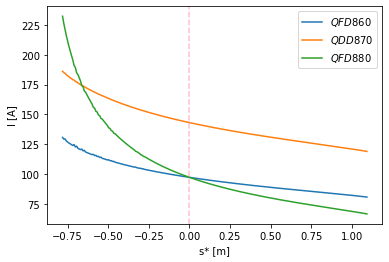

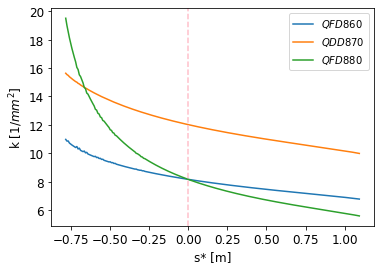

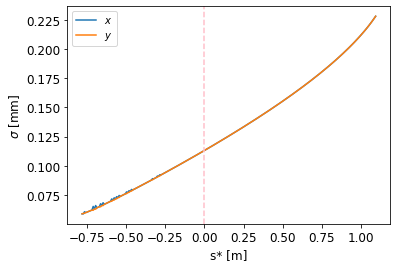

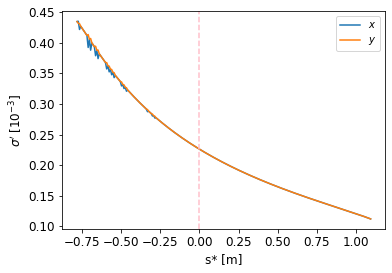

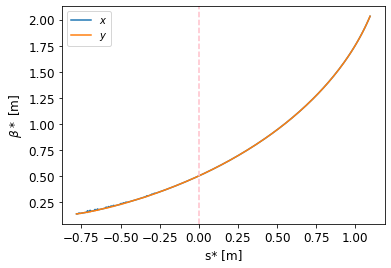

In [6]:
# Plots for Objective 1
total_I1 = np.array(sheets_data_obj1.get('list_of_I1')).flatten()
total_I2 = np.array(sheets_data_obj1.get('list_of_I2')).flatten()
total_I3 = np.array(sheets_data_obj1.get('list_of_I3')).flatten()
total_s = np.array(sheets_data_obj1.get('list_of_s')).flatten()
total_beta_x = np.array(sheets_data_obj1.get('list_of_betaX')).flatten()
total_beta_y = np.array(sheets_data_obj1.get('list_of_betaY')).flatten()
total_sigma_x = np.array(sheets_data_obj1.get('list_of_sigmaX')).flatten()
total_sigma_xp = np.array(sheets_data_obj1.get('list_of_sigmaXP')).flatten()
total_sigma_y = np.array(sheets_data_obj1.get('list_of_sigmay')).flatten()
total_sigma_yp = np.array(sheets_data_obj1.get('list_of_sigmayp')).flatten()
#print(len(total_s))

EC_QD = 0.056; # excitation constant dB/dx/I = 0.056 [T/Am]
F_QD = opticsUtils.SI_c * 1e-6 * EC_QD;
k1 = np.array(total_I1) * F_QD / P0
k2 = np.array(total_I2) * F_QD / P0
k3 = np.array(total_I3) * F_QD / P0

# ----------------------------- PLOT CURRENTS -----------------------------------------
plt.figure()
#figs, axs = plt.subplots(1,2, figsize=(3*5.787376228033763,5.787376228033763))
plt.plot(total_s, total_I1, label=f'$QFD860$')
plt.plot(total_s, total_I2, label=f'$QDD870$')
plt.plot(total_s, total_I3, label=f'$QFD880$')
plt.legend()
plt.xlabel(f's* [m]')
plt.ylabel(f'I [A]')
plt.axvline(x=0.0, color='pink', linestyle='dashed')
plt.show()

plt.figure() #figsize=(2*5.787376228033763,5.787376228033763))
plt.plot(total_s, k1, label=f'$QFD860$')
plt.plot(total_s, k2, label=f'$QDD870$')
plt.plot(total_s, k3, label=f'$QFD880$')
plt.legend()
plt.xlabel(f's* [m]',fontsize=12)
plt.ylabel(f'k [1/$mm^2$]',fontsize=12)
plt.axvline(x=0.0, color='pink', linestyle='dashed')
#plt.title(f'Magnet strength for 99 focus points')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gcf().set_figwidth(5.787376228033763)
plt.savefig('plots_obj1/Magnet_k.pdf')
plt.show()
# ----------------------------- PLOT BETA AND SIGMA ------------------------------------

plt.figure()
plt.plot(total_s, total_sigma_x, label=r'$x$')
plt.plot(total_s, total_sigma_y, label=r'$y$')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(f's* [m]', fontsize=12)
plt.ylabel(f'$\sigma$ [mm]', fontsize=12)
plt.axvline(x=0.0, color='pink', linestyle='dashed')
plt.legend()
#plt.title(f'$\sigma_x$')
plt.gcf().set_figwidth(5.787376228033763)
plt.savefig('plots_obj1/total_sigmax.pdf', bbox_inches='tight')

plt.figure()
plt.plot(total_s, total_sigma_xp, label=r"$x$")
plt.plot(total_s, total_sigma_yp, label=r"$y$")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(f's* [m]', fontsize=12)
plt.ylabel(r"$\sigma'$ [$10^{-3}$]", fontsize=12)
plt.axvline(x=0.0, color='pink', linestyle='dashed')
plt.legend()
#plt.title(f'$\sigma_x$´')
plt.gcf().set_figwidth(5.787376228033763)
plt.savefig('plots_obj1/total_sigmaxp.pdf', bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(total_s, total_beta_x, label=r'$x$')
plt.plot(total_s, total_beta_y, label=r'$y$')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(f's* [m]',fontsize=12)
plt.ylabel(r'$\beta*$ [m]',fontsize=12)
plt.axvline(x=0.0, color='pink', linestyle='dashed')
#plt.title(r'$\beta$')
plt.legend()
plt.gcf().set_figwidth(5.787376228033763)
#plt.gcf().set_figheight(5.187376228033763)
plt.savefig('plots_obj1/Total_beta.pdf')


APL INSERTED: 
-------------------------------------------------------------------------------------------------------------------------

In [7]:
filename = 'total_with_Qbeta.xlsx' #input("Enter the Excel filename (with extension): ")
sheets_data = read_excel_to_arrays(filename)

for sheet_name, array in sheets_data.items():
    print(f"Data from sheet '{sheet_name}':")

TOTAL_FOCUS = np.array(sheets_data.get('Focus_points')).squeeze()

Data from sheet 'list_of_s':
Data from sheet 'Focus_points':
Data from sheet 'list_of_I1':
Data from sheet 'list_of_I2':
Data from sheet 'list_of_I3':
Data from sheet 'list_of_betaX':
Data from sheet 'list_of_betaY':
Data from sheet 'list_of_alphaX':
Data from sheet 'list_of_alphaY':
Data from sheet 'list_of_sigmaX':
Data from sheet 'list_of_sigmaXP':
Data from sheet 'list_of_sigmaY':
Data from sheet 'list_of_sigmaYP':
Data from sheet 'list_of_k1':
Data from sheet 'list_of_k2':
Data from sheet 'list_of_k3':
Data from sheet 'list_of_betax860':
Data from sheet 'list_of_betay860':
Data from sheet 'list_of_betax870':
Data from sheet 'list_of_betay870':
Data from sheet 'list_of_betax880':
Data from sheet 'list_of_betay880':


Contour plots for total_with_Qbeta.xlsx:


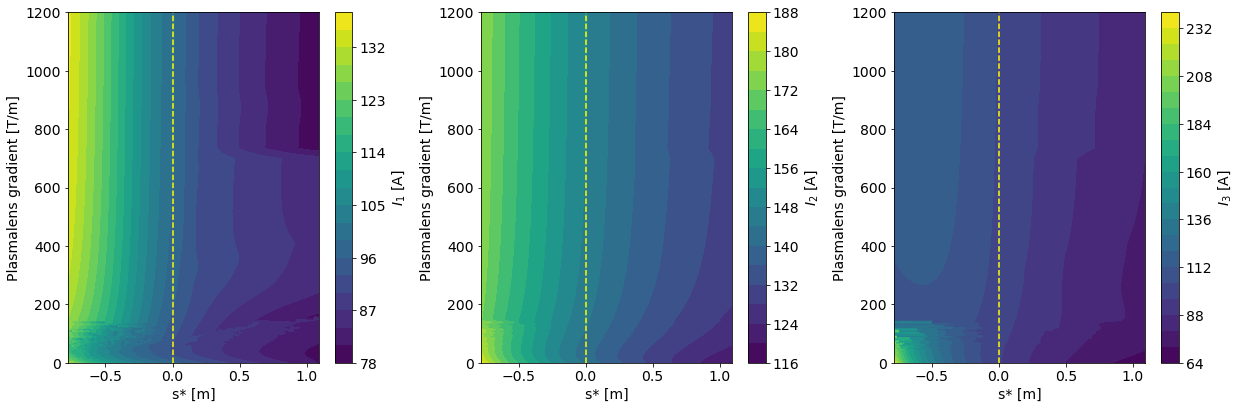

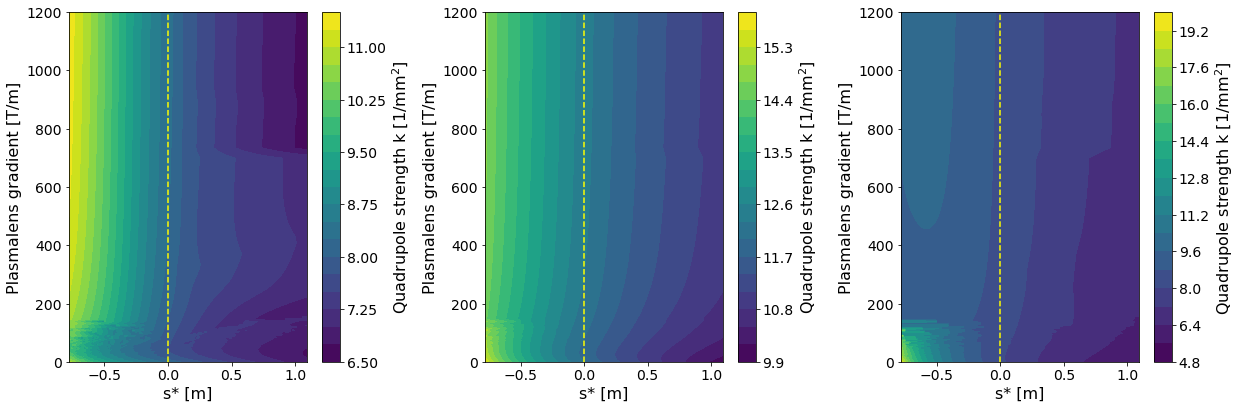

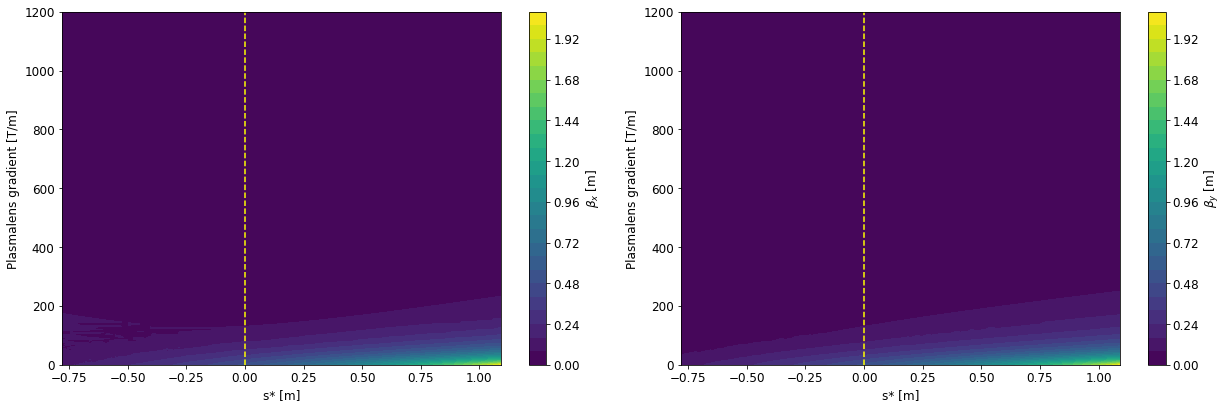

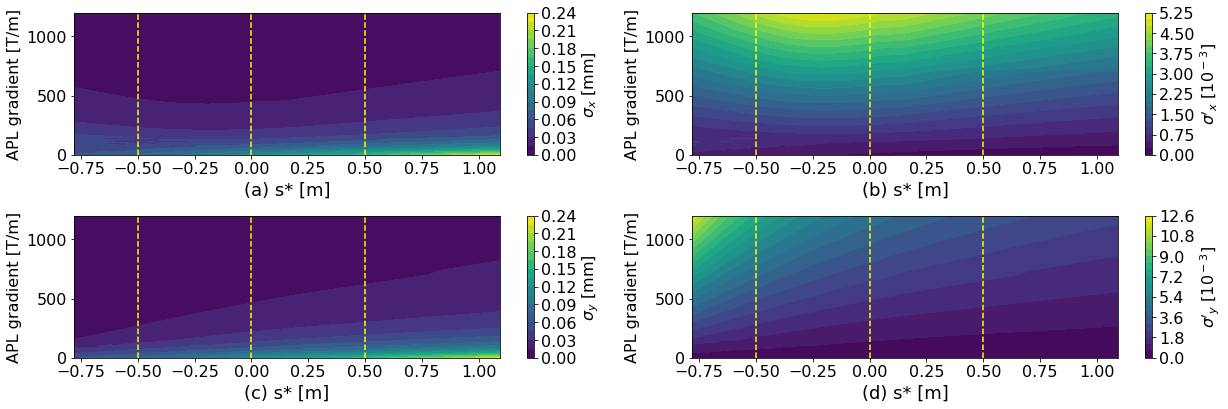

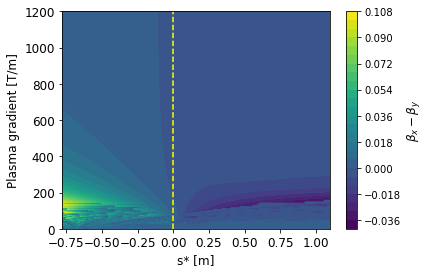

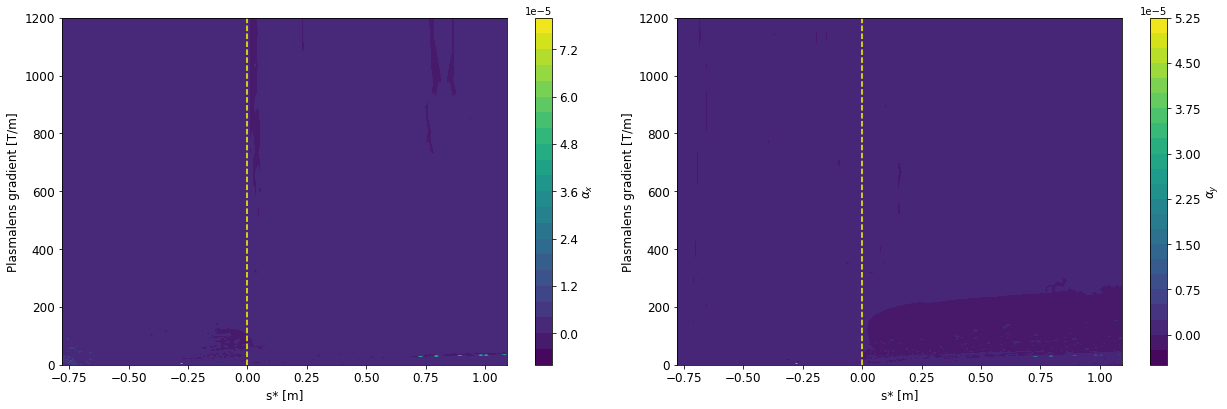

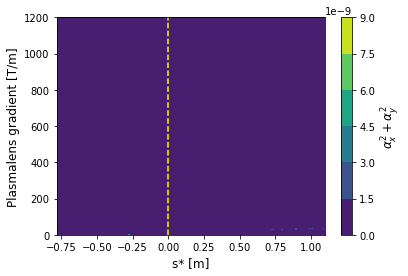

In [10]:
print(f'Contour plots for {filename}:')

#------------------------------------------------------------------------------------------------
                                # MAKE CONTOUR PLOT OF CURRENTS
#------------------------------------------------------------------------------------------------
plasma_values = np.array([0.0] + list(np.logspace(0,np.log10(1500),150,base=10)))
currents = elements.PlasmaLensUtilities.computeGradient(plasma_values,0.50)
focus_points = np.array(sheets_data.get('list_of_s')).squeeze()
X,Y = np.meshgrid(focus_points, currents)

#Get all values
A2 = np.array(sheets_data.get('list_of_alphaY')).T

#print(TOTAL_I1)
Z1 = np.array(sheets_data.get('list_of_I1')).T
Z2 = np.array(sheets_data.get('list_of_I2')).T
Z3 = np.array(sheets_data.get('list_of_I3')).T

#print(Z1.shape, Z2.shape, Z3.shape)


#axs = plt.plot(figsize=(18.6))
fig,axs = plt.subplots(1,3,figsize=(3*5.787376228033763,5.787376228033763))
#plt.xticks(fontsize=14)

c1 = axs[0].contourf(X,Y,Z1,levels=20,cmap='viridis')
#axs[0].set_title('QFD 0860')
cb1 = fig.colorbar(c1, ax=axs[0])
cb1.set_label(f'$I_1$ [A]', fontsize=14)
cb1.ax.tick_params(labelsize=14)
#plt.xticks(fontsize=12)

c2 = axs[1].contourf(X,Y,Z2,levels=20,cmap='viridis')
#axs[1].set_title('QDD 0870')
cb2 = fig.colorbar(c2, ax=axs[1])
cb2.set_label(f'$I_2$ [A]', fontsize=14)
cb2.ax.tick_params(labelsize=14)
#plt.xticks(fontsize=12)

c3 = axs[2].contourf(X,Y,Z3,levels=20,cmap='viridis')
#axs[2].set_title('QFD 0880')
cb3 = fig.colorbar(c3, ax=axs[2])
cb3.set_label(f'$I_3$ [A]', fontsize=14)
cb3.ax.tick_params(labelsize=14)

for ax in axs:
    ax.set_xlabel('s* [m]', fontsize=14)
    ax.set_ylabel('Plasmalens gradient [T/m]', fontsize=14)
    ax.axvline(x=0.0, color='yellow', linestyle='dashed')
    ax.tick_params(axis='both', labelsize=14)
    
#plt.xticks(fontsize=12)
plt.tight_layout()

plt.savefig(f'plots_obj2/Total_currents_E{P0}.pdf')
plt.show()


#------------------------------------------------------------------------------------------------
                            # QUADRUPOLE STRENGTHS
#------------------------------------------------------------------------------------------------

#print(TOTAL_I1)
K1 = (np.array(sheets_data.get('list_of_k1')).T)
K2 = np.array(sheets_data.get('list_of_k2')).T
K3 = np.array(sheets_data.get('list_of_k3')).T

#print(Z1.shape, Z2.shape, Z3.shape)

#axs = plt.plot(figsize=(18.6))
fig,axs = plt.subplots(1,3,figsize=(3*5.787376228033763,5.787376228033763))

k1 = axs[0].contourf(X,Y,K1,levels=20,cmap='viridis')
#axs[0].set_title('QFD 0860')
kk1 = fig.colorbar(k1, ax=axs[0])
kk1.set_label(f'Quadrupole strength k [1/mm$^2$]', fontsize=16)
kk1.ax.tick_params(labelsize=14)

k2 = axs[1].contourf(X,Y,K2,levels=20,cmap='viridis')
#axs[1].set_title('QDD 0870')
kk2 = fig.colorbar(k2, ax=axs[1])
kk2.set_label(f'Quadrupole strength k [1/mm$^2$]', fontsize=16)
kk2.ax.tick_params(labelsize=14)

k3 = axs[2].contourf(X,Y,K3,levels=20,cmap='viridis')
#axs[2].set_title('QFD 0880')
kk3 = fig.colorbar(k3, ax=axs[2])
kk3.set_label(f'Quadrupole strength k [1/mm$^2$] ', fontsize=16)
kk3.ax.tick_params(labelsize=14)

for ax in axs:
    ax.set_xlabel('s* [m]', fontsize=16)
    ax.set_ylabel('Plasmalens gradient [T/m]', fontsize=16)
    ax.axvline(x=0.0, color='yellow', linestyle='dashed')
    ax.tick_params(axis='both', labelsize=14)
    
#plt.axvline(x = 0.0)
plt.tight_layout()
plt.savefig(f'plots_obj2/Total_magnetK_E{P0}.pdf')
plt.show()

#------------------------------------------------------------------------------------------------
                            # CONTOUR OF BETA 
#------------------------------------------------------------------------------------------------
X1, Y1 = np.meshgrid(focus_points, currents)
#Z = np.array(list_of_betax)
Bx = np.array(sheets_data.get('list_of_betaX')).T
By = np.array(sheets_data.get('list_of_betaY')).T

# Create the meshgrid
X1, Y1 = np.meshgrid(focus_points, currents)

# Create a contour plot
#plt.figure(figsize=(10, 6))
fig1, axs1 = plt.subplots(1,2, figsize=(3*5.787376228033763,5.787376228033763))

b1 = axs1[0].contourf(X1, Y1, Bx, levels=25, cmap='viridis') #locator=ticker.LogLocator(), cmap='viridis')
#axs1[0].set_title(r'$\beta^*_x$', fontsize=12)
bb1 = fig1.colorbar(b1, ax=axs1[0])
bb1.set_label(r'$\beta_x$ [m]', fontsize=12)
bb1.ax.tick_params(labelsize=12)
#contour = plt.contourf(X1, Y1, Bx, cmap='rainbow_r')  # You can customize the colormap

b2 = axs1[1].contourf(X1, Y1, By, levels=25, cmap='viridis') #locator=ticker.LogLocator(), cmap='viridis')
#axs1[1].set_title(r'$\beta^*_y$', fontsize=12)
bb2 = fig1.colorbar(b2, ax=axs1[1])
bb2.set_label(r'$\beta_y$ [m]', fontsize=12)
bb2.ax.tick_params(labelsize=12)

for ax in axs1:
    ax.set_xlabel('s* [m]', fontsize=12)
    ax.set_ylabel('Plasmalens gradient [T/m]', fontsize=12)
    ax.axvline(x=0.0, color='yellow', linestyle='dashed')
    ax.tick_params(axis='both', labelsize=12)
    
plt.tight_layout()
plt.savefig('plots_obj2/Total_beta.pdf')
plt.show()
# Add a color bar for reference
#cbar = plt.colorbar(contour)
#cbar.set_label('Beta_x [m]')

# Add titles and labels
#plt.title('Beta_x')
#plt.xlabel('s* [m]')
#plt.ylabel('Plasma current [A]')

# Show the plot


#------------------------------------------------------------------------------------------------
                            # CONTOUR OF SIGMA
#------------------------------------------------------------------------------------------------
X2,Y2 = np.meshgrid(focus_points, currents) #[4:-1])

S1 = np.array(sheets_data.get('list_of_sigmaX')).T
S2 = np.array(sheets_data.get('list_of_sigmaXP')).T
S3 = np.sqrt(By*epsg_y)
S4 = (S3 / By) * np.sqrt(1 + A2**2)

#print(S1.shape, S2.shape)
#axs = plt.plot(figsize=(18.6))
fig2,axs2 = plt.subplots(2,2,figsize=(3*5.787376228033763,5.787376228033763))
subplot_labels = ['(a)', '(b)', '(c)', '(d)']

contour_sigma = [(axs2[0,0], S1, '$\sigma_x$ [mm]'),
                 (axs2[0,1], S2, r"$\sigma'_x$ [10$^-$$^3$]"), 
                 (axs2[1,0], S3, '$\sigma_y$ [mm]'), 
                 (axs2[1,1], S4, r"$\sigma'_y$ [10$^-$$^3$]")]

for ax, data, label, subplot_label in zip(sum(axs2.tolist(), []), [S1, S2, S3, S4], ['$\sigma_x$ [mm]', r"$\sigma'_x$ [10$^-$$^3$]", '$\sigma_y$ [mm]', r"$\sigma'_y$ [10$^-$$^3$]"], subplot_labels):
    s = ax.contourf(X2, Y2, data, levels=21, cmap='viridis')
    
    cb = fig2.colorbar(s, ax=ax)
    cb.set_label(label,fontsize=16)
    cb.ax.tick_params(labelsize=16)
    
    combined_label = f'{subplot_label} s* [m]'
    ax.set_xlabel(combined_label, fontsize=18)
    ax.set_ylabel('APL gradient [T/m]', fontsize=16)
    ax.axvline(x=0.0, color='yellow', linestyle='dashed')
    ax.axvline(x=0.5, color='yellow', linestyle='dashed')
    ax.axvline(x=-0.5, color='yellow', linestyle='dashed')
    ax.tick_params(axis='both', labelsize=16)
    
    # Subplot label
    #ax.text(0.03, 0.97, subplot_label, transform=ax.transAxes, fontsize=16, verticalalignment='top')

plt.tight_layout()
plt.savefig('plots_obj2/sigma_with_abcd.pdf')
plt.show()

#------------------------------------------------------------------------------------------------
                                  # ROUNDNESS CHECK BETA
#------------------------------------------------------------------------------------------------

BETACHECK1 = Bx-By

X3, Y3 = np.meshgrid(focus_points,currents)

contour_round = plt.contourf(X3, Y3, BETACHECK1, levels=25, cmap='viridis')
plt.axvline(x=0.0, color='yellow', linestyle='dashed')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
betabar = plt.colorbar(contour_round)
betabar.set_label(r'$\beta_x-\beta_y$', fontsize=12)
#plt.title(r'$\beta_x-\beta_y$', fontsize=12)
plt.xlabel('s* [m]', fontsize=12)
plt.ylabel('Plasma gradient [T/m]', fontsize=12)
plt.savefig('plots_obj2/Round_beta.pdf')
plt.show()
#------------------------------------------------------------------------------------------------
                                  # WAIST CHECK ALPHA
#------------------------------------------------------------------------------------------------

A1 = np.array(sheets_data.get('list_of_alphaX')).T
A2 = np.array(sheets_data.get('list_of_alphaY')).T

fig3,axs3 = plt.subplots(1,2,figsize=(3*5.787376228033763,5.787376228033763))

a1 = axs3[0].contourf(X3,Y3,A1,levels=25,cmap='viridis')
#axs3[0].set_title(r'$\alpha_x$', fontsize=12)
ab1 = fig3.colorbar(a1, ax=axs3[0])
ab1.set_label(r'$\alpha_x$', fontsize=12)
ab1.ax.tick_params(labelsize=12)

a2 = axs3[1].contourf(X3,Y3,A2,levels=25,cmap='viridis')
#axs3[1].set_title(r'$\alpha_y$', fontsize=12)
ab2 = fig3.colorbar(a2, ax=axs3[1])
ab2.set_label(r'$\alpha_y$ ', fontsize=12)
ab2.ax.tick_params(labelsize=12)

#c3 = axs[2].contourf(X,Y,Z3,levels=20,cmap='tab20')
#axs[2].set_title('QFD 0880')
#cb3 = fig.colorbar(c3, ax=axs[2])
#cb3.set_label(f'$I_3$ [A]')

for ax in axs3:
    ax.set_xlabel('s* [m]', fontsize=12)
    ax.set_ylabel('Plasmalens gradient [T/m]', fontsize=12)
    ax.axvline(x=0.0, color='yellow', linestyle='dashed')
    ax.tick_params(axis='both', labelsize=12)
    
plt.tight_layout()
plt.show()

ALPHACHECK = A1**2 + A2**2

contour_round_alpha = plt.contourf(X3, Y3, ALPHACHECK, cmap='viridis')
plt.axvline(x=0.0, color='yellow', linestyle='dashed')
alphabar = plt.colorbar(contour_round_alpha)
alphabar.set_label(r'$\alpha_x^2 + \alpha_y^2$', fontsize=12)
#plt.title(r'$\alpha_x^2 + \alpha_y^2$')
plt.xlabel('s* [m]', fontsize=12)
plt.ylabel('Plasmalens gradient [T/m]', fontsize=12)
plt.savefig('plots_obj2/alpha_squared.pdf', bbox_inches='tight')
plt.show()



Sigma (beam propagation), beta and alfa for any plasmacurrent (0,1500) and any focus point between 17.4-19.275:
----------------

Focuspoints and plasmacurrents for total_with_Qbeta.xlsx:
Rounded currents are I1=86.31, I2=130.64 and I3=79.2
s_line: 19.19768181818182
s-coordinate of s*=0: [1.01618182]
For sigma_x = 0.02623561635262744, the calculated sigma_xp = 0.9751102795703454
For sigma_y = 0.02790527615194793, the calculated sigma_xp = 0.9167663870090378
The closest value to plasma current 500 is 509.4929597629855
The closest value to focus point 19.2 is 19.19768181818182
Magnet strength k in quadrupoles are k1 = 7.245024373994401, k2 = 10.9661682796736, k3 = 6.648197548608
Focus point = 19.19768181818182 [m] for plasmacurrent = 509.4929597629855 [A]


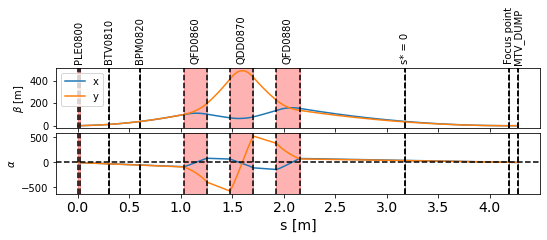

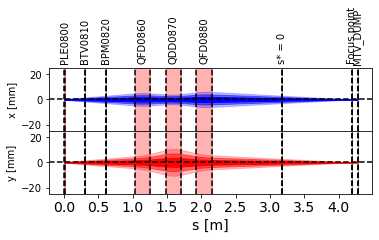

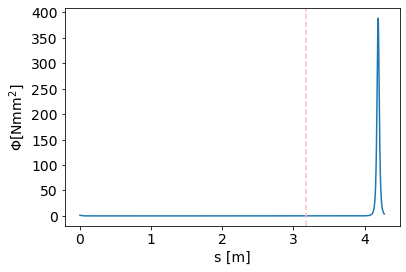

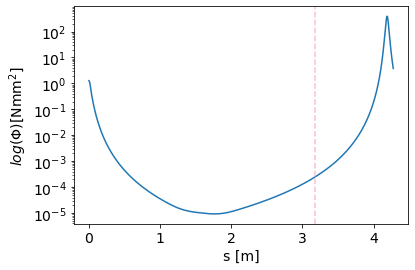

#  s[m] element_name         typeName            betax[m] betay[m]         alphax[m]        alphay[m] sigmax[mm] sigmay[mm]    x[mm]    y[mm]    dx/ds[1e-3]    dy/ds[1e-3]
###########################################################################################################################################################################
    0.0 START                -----                 0.5002   0.5002              0.02             0.02    0.11312    0.11312      0.0      0.0            0.0            0.0
   0.02 PLE0800              QuadThick            0.63266  0.63266            -7.174           -7.174    0.12722    0.12722      0.0      0.0            0.0            0.0
  0.302 drift_24             Drift                 11.274   11.274            -30.56           -30.56    0.53704    0.53704      0.0      0.0            0.0            0.0
  0.302 BTV0810              Marker                11.274   11.274            -30.56           -30.56    0.53704    0.53704      0.0      0.

In [13]:
plasma_values = np.array([0.0] + list(np.logspace(0,np.log10(1500),150,base=10)))

def latticeplot(plasma,focus, doPrint=True,s_star=True, rounding=True): 
    EC_QD = 0.056; # excitation constant dB/dx/I = 0.056 [T/Am]
    F_QD = opticsUtils.SI_c * 1e-6 * EC_QD;
    #TOTAL_k1 = np.array(TOTAL_I1) * F_QD / P0
    
    TOTAL_I1 = np.array(sheets_data.get('list_of_I1')).T
    TOTAL_I2 = np.array(sheets_data.get('list_of_I2')).T
    TOTAL_I3 = np.array(sheets_data.get('list_of_I3')).T
    #print("length of I1:", len(TOTAL_I1))
    
    TOTAL_FOCUS = list(np.array(sheets_data.get('Focus_points')).squeeze())

    target1 = plasma
    closest_value1 = min(plasma_values, key=lambda x: abs(x - target1))
    index1 = list(plasma_values).index(closest_value1)
    
    target2 = focus
    closest_value2 = min(TOTAL_FOCUS, key=lambda x: abs(x-target2))
    index2 = TOTAL_FOCUS.index(closest_value2)

    I4_plot = plasma_values[index1]
    
    if rounding:
        I1_plot = round(TOTAL_I1[index1][index2],2)
        I2_plot = round(TOTAL_I2[index1][index2],2)
        I3_plot = round(TOTAL_I3[index1][index2],2)
    
        print(f"Rounded currents are I1={I1_plot}, I2={I2_plot} and I3={I3_plot}")
    else:  
        I1_plot = TOTAL_I1[index1][index2]
        I2_plot = TOTAL_I2[index1][index2]
        I3_plot = TOTAL_I3[index1][index2]
    
        print(f"Currents (NO ROUNDING) are I1={I1_plot}, I2={I2_plot} and I3={I3_plot}")
    
    total_sigmaX = np.array(sheets_data.get('list_of_sigmaX')).T
    total_sigmaXP = np.array(sheets_data.get('list_of_sigmaXP')).T
    total_sigmaY = np.array(sheets_data.get('list_of_sigmaY')).T
    total_sigmaYP = np.array(sheets_data.get('list_of_sigmaYP')).T
    s_plot = np.array(sheets_data.get('list_of_s')).T
    
    sigmax_plot = total_sigmaX[index1]
    sigmaxp_plot = total_sigmaXP[index1]
    sigmay_plot = total_sigmaY[index1]
    sigmayp_plot = total_sigmaYP[index1]

    s_line = TOTAL_FOCUS[index2]
    print("s_line:", s_line)
    print("s-coordinate of s*=0:", s_plot[index2])
    
    #Find sigma prime
    #sigma_xp = (total_sigmaX[index1][index2] / Bx[index1][index2] * np.sqrt(1 + A1[index1][index2]**2))
    #sigma_yp = (total_sigmaY[index1][index2] / By[index1][index2] * np.sqrt(1 + A2[index1][index2]**2))
    sigma_xp = S2[index1][index2]
    sigma_yp = S4[index1][index2]
    
    print(f'For sigma_x = {total_sigmaX[index1][index2]}, the calculated sigma_xp = {sigma_xp}')
    print(f'For sigma_y = {total_sigmaY[index1][index2]}, the calculated sigma_xp = {sigma_yp}')

    latticeCLEAR_PLE = lattice(s_line,s_star)

    latticeCLEAR_PLE.elements['QFD0860'].update(I1_plot, P0)
    latticeCLEAR_PLE.elements['QDD0870'].update(-I2_plot, P0)
    latticeCLEAR_PLE.elements['QFD0880'].update(I3_plot, P0)
    latticeCLEAR_PLE.elements['PLE0800'].update(-I4_plot, P0)

    (sp,xtp,ytp, xTrap,yTrap, sSubp,xtSubp,ytSubp,xTraSubp,yTraSubp) = latticeCLEAR_PLE.computeTwiss(xt_init,yt_init, subdivide=1e-3)

    # Calculate pseudo-dose
    A = 1/(np.pi*xtSubp[0]*ytSubp[0])
    
    list_pos = [sSubp, A]
    
    # Magnet strengths
    EC_QD = 0.056; # excitation constant dB/dx/I = 0.056 [T/Am]
    F_QD = opticsUtils.SI_c * 1e-6 * EC_QD;
    
    k1 = I1_plot * F_QD / P0
    k2 = I2_plot * F_QD / P0
    k3 = I3_plot * F_QD / P0
    
    if doPrint:
        
        print(f"The closest value to plasma current {target1} is {closest_value1}")
        print(f"The closest value to focus point {target2} is {closest_value2}")
        print(f"Magnet strength k in quadrupoles are k1 = {k1}, k2 = {k2}, k3 = {k3}")
        print(f"Focus point = {s_line} [m] for plasmacurrent = {I4_plot} [A]")
        
        (ax_beta_p,ax_alpha_p) = plot.alphaBeta(sp,xtSubp,ytSubp, sSubp)
        plot.addElemsToPlot(ax_beta_p,latticeCLEAR_PLE)
        plot.addElemsToPlot(ax_alpha_p,latticeCLEAR_PLE)
        plot.addElemNamesToPlot(ax_beta_p,latticeCLEAR_PLE, ypos=1.1)
        plt.gcf().set_figwidth(5.787376228033763*1.5)
        plt.gcf().set_figheight(5.787376228033763/2.5)
        #plt.xticks(fontsize=14)
        plt.xlabel('s [m]', fontsize=14)
        ticks = np.arange(0, np.max(sp), 0.5)
        plt.xticks(ticks, fontsize=14)
        
        #ax_beta_p.set_ylim([0,7000])
        #ax_alpha_p.set_ylim([-10000,10000])
        ax_beta_p.legend(loc='best')
        #plt.savefig(f'plots_obj2/Alpha_beta/Alphabeta{closest_value1:.1f}_focus{s_line:.2f}.pdf',bbox_inches='tight')
        
        # SIGMAPLOT (WAIST)
        (ax1_p,ax2_p) = plot.sigmas(sp,xtSubp,ytSubp,(epsg_x,epsg_y), xTraSubp,yTraSubp, sSub=sSubp, equalY=True)
        plot.addElemsToPlot(ax1_p,latticeCLEAR_PLE)
        plot.addElemsToPlot(ax2_p,latticeCLEAR_PLE)
        plot.addElemNamesToPlot(ax1_p,latticeCLEAR_PLE, ypos=1.1)
        ax1_p.set_ylim([-25,25])
        ax2_p.set_ylim([-25,25])
        plt.gcf().set_figwidth(5.787376228033763*1.0)
        plt.gcf().set_figheight(5.787376228033763/2.5)
        plt.xticks(fontsize=14)
        plt.xlabel('s [m]', fontsize=14)
        plt.xticks(ticks, fontsize=14)
        #ax1_p.set_ylim([-2,2])
        #ax2_p.set_ylim([-1.5,1.5])
        #plt.savefig(f'plots_obj2/Beam_waist/Waist_plasma{closest_value1:.1f}_focus{s_line:.2f}.pdf', bbox_inches='tight')

        plt.show()

        # ------- PLOT THE FLUENCE ---------------------------------------------------------------------------------------------
        plt.figure()
        dose = plt.plot(sSubp, A)
        plt.axvline(x=3.174, color='pink', linestyle='dashed')
        #plot.addElemsToPlot(dose, latticeCLEAR_PLE)
        #plot.addElemNamesToPlot(ax1_p, latticeCLEAR_PLE)
        #plt.title(f'$1/(\pi\sigma_x\sigma_y$)')
        plt.xlabel('s [m]', fontsize=14)
        plt.ylabel(r'$\Phi$[Nmm$^2$]', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        #plt.savefig(f'plots_obj2/Dose_area/sigma_area_plasma{closest_value1:.1f}_focus{s_line:.2f}.pdf', bbox_inches='tight')
        plt.show()
        
        # LOGARITHMIC SCALE FLUENCE
        dose_log = plt.semilogy(sSubp, A)
        plt.axvline(x=3.174, color='pink', linestyle='dashed')
        #plot.addElemsToPlot(dose, latticeCLEAR_PLE)
        #plot.addElemNamesToPlot(ax1_p, latticeCLEAR_PLE)
        #plt.title(f'$1/(\pi\sigma_x\sigma_y$)')
        plt.xlabel('s [m]', fontsize=14)
        plt.ylabel(r'$log(\Phi)$[Nmm$^2$]', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        #plt.savefig(f'plots_obj2/Dose_area/sigma_area_log_plasma{closest_value1:.1f}_focus{s_line:.2f}.pdf', bbox_inches='tight')
        plt.show()
        
        final_res = opticsUtils.printLatticeOptics(latticeCLEAR_PLE, sp, xtp, ytp, epsg_x,epsg_y, xTrap, yTrap)
        
    final_res = 'No printed results'
    return final_res, s_line, [I1_plot, I2_plot, I3_plot], I4_plot, list_pos, sigmax_plot, sigmaxp_plot, sigmay_plot, sigmayp_plot, TOTAL_FOCUS, total_sigmaX[index1][index2], total_sigmaY[index1][index2]

#-----------------------------------------------------------------------------------------------------------------------------
## PLOT THE WAIST
# FOCUS POINT GIVEN IN s REFERENCING THE FULL LATTICE (see CLEARST_survey0.tfs) and APL current in [I]
#CALL FUNCTION AS: latticeplot(APLcurrent, focuspoint, doPrint, s_star, rounding)
print(f'Focuspoints and plasmacurrents for {filename}:')
waist = latticeplot(500, 19.2, doPrint=True, s_star=True, rounding=True)


## Combine several fluences for different APL: 

Rounded currents are I1=81.87, I2=120.72 and I3=68.34
s_line: 19.19768181818182
s-coordinate of s*=0: [1.01618182]
For sigma_x = 0.2144364503428129, the calculated sigma_xp = 0.1193016353115927
For sigma_y = 0.2144364226544892, the calculated sigma_xp = 0.11930165071598287
Rounded currents are I1=81.39, I2=121.52 and I3=69.66
s_line: 19.19768181818182
s-coordinate of s*=0: [1.01618182]
For sigma_x = 0.1957963256212182, the calculated sigma_xp = 0.1306593426365505
For sigma_y = 0.1957962978423315, the calculated sigma_xp = 0.1306593611739884
Rounded currents are I1=80.8, I2=123.74 and I3=72.79
s_line: 19.19768181818182
s-coordinate of s*=0: [1.01618182]
For sigma_x = 0.1420370330521562, the calculated sigma_xp = 0.1801123175173389
For sigma_y = 0.1420369462759094, the calculated sigma_xp = 0.18011242755540535
Rounded currents are I1=82.07, I2=125.77 and I3=74.65
s_line: 19.19768181818182
s-coordinate of s*=0: [1.01618182]
For sigma_x = 0.1022317871802059, the calculated sigma_xp = 0.250

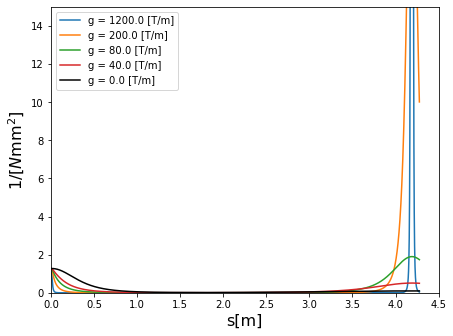

In [15]:
focus_dose = 19.2 # FOCUS POINT GIVEN IN s FROM FULL LATTICE, CHANGE TO HAVE FLUENCE PEAK IN DIFFERENT POINT

# Generate several doseplots and combine them together
plasma_0_focus_sym = latticeplot(0.0, focus_dose, doPrint=False, s_star=True)[4]
plasma_10_focus_sym = latticeplot(10.0, focus_dose, doPrint=False, s_star=True)[4]
plasma_50_focus_sym = latticeplot(50.0, focus_dose, doPrint=False, s_star=True)[4]
plasma_100_focus_sym = latticeplot(100.0, focus_dose, doPrint=False, s_star=True)[4]
plasma_250_focus_sym = latticeplot(250.0, focus_dose, doPrint=False, s_star=True)[4]
plasma_500_focus_sym = latticeplot(500.0, focus_dose, doPrint=False, s_star=True)[4]
plasma_1000_focus_sym = latticeplot(1000.0, focus_dose, doPrint=False, s_star=True)[4]
plasma_1500_focus_sym = latticeplot(1500.0, focus_dose, doPrint=False, s_star=True)[4]

plt.figure(figsize=(5.787376228033763*1.2, 5.787376228033763/1.1))

plt.plot(plasma_1500_focus_sym[0], plasma_1500_focus_sym[1], label=f'g = {elements.PlasmaLensUtilities.computeGradient(1500,0.50):.1f} [T/m]')#, color='gray')
#plt.plot(plasma_1000_focus_sym[0], plasma_1000_focus_sym[1], label=f'g = {elements.PlasmaLensUtilities.computePlasmaK(1000,0.50,P0):.1f} [T/m]', color='gray')
#plt.plot(plasma_500_focus_sym[0], plasma_500_focus_sym[1], label=f'g = {elements.PlasmaLensUtilities.computePlasmaK(500,0.50,P0):.1f} [T/m]', color='green')
plt.plot(plasma_250_focus_sym[0], plasma_250_focus_sym[1], label=f'g = {elements.PlasmaLensUtilities.computeGradient(250,0.50):.1f} [T/m]')#, color='purple')
plt.plot(plasma_100_focus_sym[0], plasma_100_focus_sym[1], label=f'g = {elements.PlasmaLensUtilities.computeGradient(100,0.50):.1f} [T/m]')#, color='orange')
plt.plot(plasma_50_focus_sym[0], plasma_50_focus_sym[1], label=f'g = {elements.PlasmaLensUtilities.computeGradient(50,0.50):.1f} [T/m]')#, color='red')
plt.plot(plasma_0_focus_sym[0], plasma_0_focus_sym[1], label=f'g = {elements.PlasmaLensUtilities.computeGradient(0,0.50):.1f} [T/m]', color='black')
#plt.plot(plasma_10_focus_sym[0], plasma_10_focus_sym[1], label=f'Plasma current = {10.0} [A]')

plt.ylim([0,15])
plt.xlim([0,4.5])
plt.xlabel('s[m]', fontsize=16)
plt.ylabel(f'1/[$N$mm$^2$]', fontsize=16)
plt.legend()
plt.savefig(f'plots_obj2/Pseudo_dose_plot_focus{focus_dose}.pdf')
plt.show()

## Include matching section

In [16]:
def full_lattice(focus, s_star=True):
    # Fix the setup of the quadrupoles
    latticeCLEAR = clearST_survey0_tfs.buildLattice(P0, doFinalize=False)
    sPLE = latticeCLEAR.getElemS('PLE0800M') # Get the position of the middle of the plasmalens
    latticeCLEAR.implicitSeq_removeElem('CA.DHJ0780') # Remove kicker magnet from the setup
    latticeCLEAR.implicitSeq_removeElem('BTV0800') # Remove to avoid overlapping elements when adding PLE
    latticeCLEAR.implicitSeq_removeElem('PLE0800M') # Remove the marker for the plasmalens
    latticeCLEAR.implicitSeq_removeElem('CA.DHJ0840') # Remove kicker magnet from the setup
    latticeCLEAR.implicitSeq_addElem(elements.CLEAR_Q(0.0, P0), 'QFD0860', 16.2625, refer='end', referFrom=None) # Add focusing magnet
    latticeCLEAR.implicitSeq_addElem(elements.Marker(),'P', 15.007499999999999) #Mark the start of the plasmalens  
    #latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Start', 14.400)
    if s_star:
        latticeCLEAR.implicitSeq_addElem(elements.Marker(), 's* = 0', 18.1815)

    # Remove some markers for a simpler setup (easier to read the plot)
    latticeCLEAR.implicitSeq_removeElem('CA.QS0870')
    latticeCLEAR.implicitSeq_removeElem('CA.BPM0890')
    latticeCLEAR.implicitSeq_removeElem('CA.CLEAR$END')
    latticeCLEAR.implicitSeq_removeElem('CA.CLDUMP$START')
    latticeCLEAR.implicitSeq_removeElem('CA.VAW0915')
    latticeCLEAR.implicitSeq_removeElem('CA.ICT0930')
    latticeCLEAR.implicitSeq_removeElem('CLDUMP$END')
    latticeCLEAR.implicitSeq_removeElem('CA.BTV0910') # Fjernet pga jeg får trøbbel med optimeringen 
    #latticeCLEAR.implicitSeq_finalize()

    # Add markers for different focal points
    #latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Focus point', 18.1815) # Dette er fokuspunktet som er symmetrisk
    latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Focus point', focus)
    #latticeCLEAR.implicitSeq_finalize()

    # ADD PLASMALENS
    latticeCLEAR.implicitSeq_addElem( elements.CLEAR_PlasmaLens( 20e-3, 0.50, 0.0, P0 ), 'PLE0800', sPLE)

    latticeCLEAR.implicitSeq_finalize()

    latticeCLEAR_PLE = latticeCLEAR.getSubLattice('BTV0730')
    
    return latticeCLEAR_PLE

#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------

# STARTING POINT (IMPORTANT: MUST BE "INSIDE" AREA WHERE YOU WANT TO PLOT - AKA AFTER BTV0910, BEFORE DUMP)
focus0 = 18.1815 
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------

#Update currents for propagating
latticeCLEAR_PLE = full_lattice(focus0, s_star=True)

Maximal fluence for plasma gradient 800.0  7300.25680363307
The closest value to plasma current 1000 is 1012.8913663118116
The closest value to focus point 19.2 is 19.19768181818182
Currents in quadrupoles are I1 = 80.20775489231205, I2 = 130.9306778444389, I3 = 84.0329148311665
Focusing strengths in quadrupoles are k1 = 6.7327903971517715, k2 = 10.990568326805334, k3 = 7.053881545239217
Focus point = 19.19768181818182 [m] for plasmacurrent = 1012.8913663118116 [A]


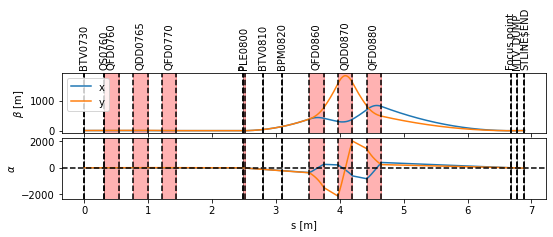

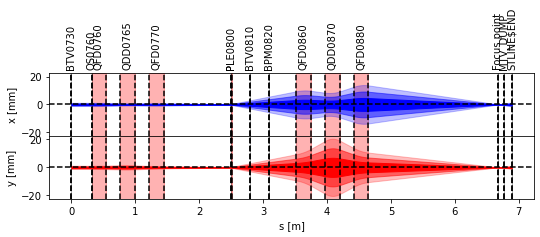

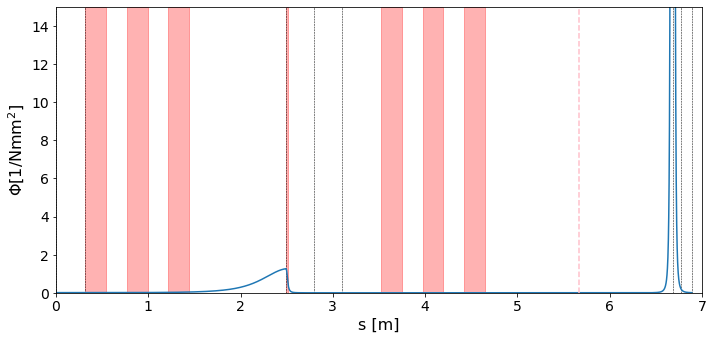

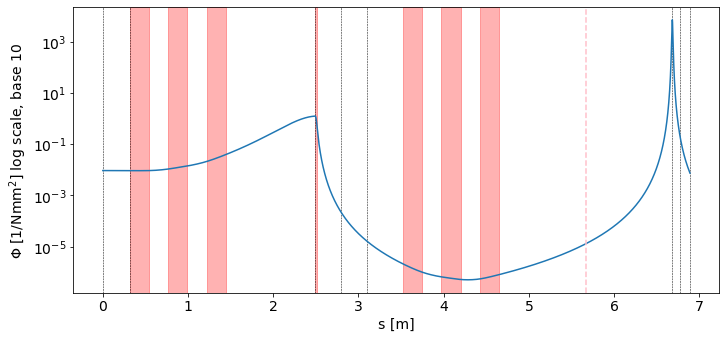

#  s[m] element_name         typeName            betax[m] betay[m]         alphax[m]        alphay[m] sigmax[mm] sigmay[mm]    x[mm]    y[mm]    dx/ds[1e-3]    dy/ds[1e-3]
###########################################################################################################################################################################
    0.0 START                -----                 5.8163   5.8163       -2.6841e-08       3.9905e-08    0.38574    0.38574      0.0      0.0            0.0            0.0
    0.0 BTV0730              Marker                5.8163   5.8163       -2.6841e-08       3.9905e-08    0.38574    0.38574      0.0      0.0            0.0            0.0
  0.317 drift_19             Drift                 5.8336   5.8336         -0.054502        -0.054502    0.38631    0.38631      0.0      0.0            0.0            0.0
  0.317 QS0760               Marker                5.8336   5.8336         -0.054502        -0.054502    0.38631    0.38631      0.0      0.

In [17]:
# ---- NEW INITIAL TWISS PARAMETRES FOUND THROUGH BACKPROPAGATION ----------
beta0x_match = 5.8163
beta0y_match = 5.8163
alpha0x_match = -2.6841e-08
alpha0y_match = 3.9905e-08

# --------------------------------------------------------------------------

xt_match = np.asarray([beta0x_match, alpha0x_match, opticsUtils.getGamma(alpha0x_match,beta0x_match)])
yt_match = np.asarray([beta0y_match, alpha0y_match, opticsUtils.getGamma(alpha0y_match,beta0y_match)])

QFD880 = latticeCLEAR_PLE.getTwissIdx("QFD0880")
PLE_ind = latticeCLEAR_PLE.getTwissIdx("PLE0800")
#print(xt_match)

def find_k(I):
    EC_QD = 0.056; # excitation constant dB/dx/I = 0.056 [T/Am]
    F_QD = opticsUtils.SI_c * 1e-6 * EC_QD;
    k = I * F_QD / P0
    return k

def latticeplot_full(plasma,focus, doPrint=True, s_star=True): 
    
    TOTAL_I1 = np.array(sheets_data.get('list_of_I1')).T
    TOTAL_I2 = np.array(sheets_data.get('list_of_I2')).T
    TOTAL_I3 = np.array(sheets_data.get('list_of_I3')).T
    
    total_s = np.array(sheets_data.get('list_of_s')).T
    
    TOTAL_FOCUS = list(np.array(sheets_data.get('Focus_points')).squeeze())

    target1 = plasma
    closest_value1 = min(plasma_values, key=lambda x: abs(x - target1))
    index1 = list(plasma_values).index(closest_value1)
    
    target2 = focus
    closest_value2 = min(TOTAL_FOCUS, key=lambda x: abs(x-target2))
    index2 = TOTAL_FOCUS.index(closest_value2)

    I4_plot = plasma_values[index1]
    I1_plot = TOTAL_I1[index1][index2]
    I2_plot = TOTAL_I2[index1][index2]
    I3_plot = TOTAL_I3[index1][index2]
    
    total_sigmaX = np.array(sheets_data.get('list_of_sigmaX')).T
    total_sigmaXP = np.array(sheets_data.get('list_of_sigmaXP')).T
    total_sigmaY = np.array(sheets_data.get('list_of_sigmaY')).T
    total_sigmaYP = np.array(sheets_data.get('list_of_sigmaYP')).T

    s_line = TOTAL_FOCUS[index2]
    #print("s_line:", s_line)

    latticeCLEAR_PLE = full_lattice(s_line, s_star)
    I5_opt_final = 50.45 #50.45158424287409
    I6_opt_final = 99.99 #99.98718038259402
    I7_opt_final = 66.96 #66.96353810870805 
    
    # Matching triplet
    latticeCLEAR_PLE.elements['QFD0760'].update(I5_opt_final, P0)
    latticeCLEAR_PLE.elements['QDD0765'].update(-I6_opt_final, P0)
    latticeCLEAR_PLE.elements['QFD0770'].update(I7_opt_final, P0)

    latticeCLEAR_PLE.elements['QFD0860'].update(I1_plot, P0)
    latticeCLEAR_PLE.elements['QDD0870'].update(-I2_plot, P0)
    latticeCLEAR_PLE.elements['QFD0880'].update(I3_plot, P0)
    latticeCLEAR_PLE.elements['PLE0800'].update(-I4_plot, P0)

    (sp,xtp,ytp, xTrap,yTrap, sSubp,xtSubp,ytSubp,xTraSubp,yTraSubp) = latticeCLEAR_PLE.computeTwiss(xt_match,yt_match, subdivide=1e-3)
    
    alphax_880 = xtp[1, QFD880]
    alphay_880 = ytp[1, QFD880]
    alphax_PLE = xtp[1, PLE_ind]
    alphay_PLE = ytp[1, PLE_ind]
    betax_880 = xtp[0, QFD880]
    betay_880 = ytp[0, QFD880]
    betax_PLE = xtp[0, PLE_ind]
    betay_PLE = ytp[0, PLE_ind]
    
    QFD880Twiss = [betax_880, betay_880, alphax_880, alphay_880]
    APLTwiss = [betax_PLE, betay_PLE, alphax_PLE, alphay_PLE]
    
    sigmaXP_QFD880 = (total_sigmaX[index1][QFD880] / betax_PLE) * np.sqrt(1 + (alphax_PLE)**2)
    sigmaYP_QFD880 = (total_sigmaY[index1][QFD880] / betay_PLE) * np.sqrt(1 + (alphay_PLE)**2)
    
    sigmaXP_APL = (total_sigmaX[index1][PLE_ind] / betax_PLE) * np.sqrt(1 + (alphax_PLE)**2)
    sigmaYP_APL = (total_sigmaY[index1][PLE_ind] / betay_PLE) * np.sqrt(1 + (alphay_PLE)**2)

    # Calculate dose
    A = 1/(np.pi*xtSubp[0]*ytSubp[0])
    list_pos = [sSubp, A]
    
    fluence_in_focus_point = np.max(A)
    
    if doPrint:
        
        print(f"Maximal fluence for plasma gradient {elements.PlasmaLensUtilities.computeGradient(target1,0.50):.1f} ", fluence_in_focus_point)
        print(f"The closest value to plasma current {target1} is {closest_value1}")
        print(f"The closest value to focus point {target2} is {closest_value2}")
        print(f"Currents in quadrupoles are I1 = {I1_plot}, I2 = {I2_plot}, I3 = {I3_plot}")
        print(f"Focusing strengths in quadrupoles are k1 = {find_k(I1_plot)}, k2 = {find_k(I2_plot)}, k3 = {find_k(I3_plot)}")
        print(f"Focus point = {s_line} [m] for plasmacurrent = {I4_plot} [A]")
        
        (ax_beta_p,ax_alpha_p) = plot.alphaBeta(sp,xtSubp,ytSubp, sSubp)
        plot.addElemsToPlot(ax_beta_p,latticeCLEAR_PLE)
        plot.addElemsToPlot(ax_alpha_p,latticeCLEAR_PLE)
        plot.addElemNamesToPlot(ax_beta_p,latticeCLEAR_PLE, ypos=1.1)
        plt.gcf().set_figwidth(5.787376228033763*1.5)
        plt.gcf().set_figheight(5.787376228033763/2.5)
        #ax_beta_p.set_ylim([0,7000])
        #ax_alpha_p.set_ylim([-10000,10000])
        ax_beta_p.legend(loc='best')
        plt.savefig(f'plots_obj3/Alphabeta{closest_value1:.1f}_focus{s_line:.2f}.pdf',bbox_inches='tight')
        
        (ax1_p,ax2_p) = plot.sigmas(sp,xtSubp,ytSubp,(epsg_x,epsg_y), xTraSubp,yTraSubp, sSub=sSubp, equalY=True)
        plot.addElemsToPlot(ax1_p,latticeCLEAR_PLE)
        plot.addElemsToPlot(ax2_p,latticeCLEAR_PLE)
        plot.addElemNamesToPlot(ax1_p,latticeCLEAR_PLE, ypos=1.1)
        #ax1_p.set_ylim([-20,20])
        #ax2_p.set_ylim([-25,25])
        plt.gcf().set_figwidth(5.787376228033763*1.5)
        plt.gcf().set_figheight(5.787376228033763/2.5)
        #ax1_p.set_ylim([-2,2])
        #ax2_p.set_ylim([-1.5,1.5])
        #plt.savefig(f'plots_obj2/Beam_waist/Waist_plasma{closest_value1:.1f}_focus{s_line:.2f}.pdf', bbox_inches='tight')

        plt.show()
        
        # ----------------------------- FLUENCE PLOTS ---------------------------------------------------------------------

        plt.figure(figsize=(5.787376228033763*2, 5.787376228033763/1.1))
        plt.plot(sSubp, A)
        ax = plt.gca()
        plot.addElemsToPlot(ax, latticeCLEAR_PLE)
        #plt.title(f'$1/(\pi\sigma_x\sigma_y$)')
        plt.ylim([0,15])
        plt.xlim([0.0,7])
        plt.xlabel('s [m]', fontsize=16)
        plt.ylabel(r'$\Phi$[1/Nmm$^2$]', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.axvline(x=5.668, color='pink', linestyle='dashed')
        plt.savefig(f'plots_obj3/sigma_area_plasma{closest_value1:.1f}_focus{s_line:.2f}.pdf', bbox_inches='tight')
        plt.show()
        
        plt.figure(figsize=(5.787376228033763*2, 5.787376228033763/1.1))
        dose_log = plt.semilogy(sSubp, A)
        ax1 = plt.gca()
        #ax1.plot(sSubp, A)
        #ax1.set_yscale('log', base=np.e)
        plot.addElemsToPlot(ax1, latticeCLEAR_PLE)
        plt.axvline(x=5.668, color='pink', linestyle='dashed')
        #plot.addElemsToPlot(dose, latticeCLEAR_PLE)
        #plot.addElemNamesToPlot(ax1_p, latticeCLEAR_PLE)
        #plt.title(f'$1/(\pi\sigma_x\sigma_y$)')
        plt.xlabel('s [m]', fontsize=14)
        plt.ylabel(r'$\Phi$ [1/Nmm$^2$] log scale, base 10 ', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.savefig(f'plots_obj3/sigma_area_log_plasma{closest_value1:.1f}_focus{s_line:.2f}.pdf', bbox_inches='tight')
        plt.show()
    
        final_res = opticsUtils.printLatticeOptics(latticeCLEAR_PLE, sp, xtp, ytp, epsg_x,epsg_y, xTrap, yTrap)
        
    final_res = 'No printed results'
    return final_res, s_line, [I1_plot, I2_plot, I3_plot], I4_plot, list_pos, fluence_in_focus_point, sp, total_sigmaX[index1][index2], total_sigmaY[index1][index2], sigmaXP_QFD880, sigmaXP_APL, sigmaYP_APL, sigmaYP_QFD880, QFD880Twiss, APLTwiss

#-----------------------------------------------------------------------------------------------------------------------------
## PLOT THE WAIST

APL = 1000
waist = latticeplot_full(APL, 19.2, doPrint=True, s_star=False)

Twiss_in_880 = waist[13]
betax_in_880 = Twiss_in_880[0]
betay_in_880 = Twiss_in_880[1]

print(f"beta_x in QFD880 = {betax_in_880}")
print(f"beta_y in QFD880 = {betay_in_880}")

print("APL g =", elements.PlasmaLensUtilities.computeGradient(APL,0.50))



## Fluence plots with full lattice:

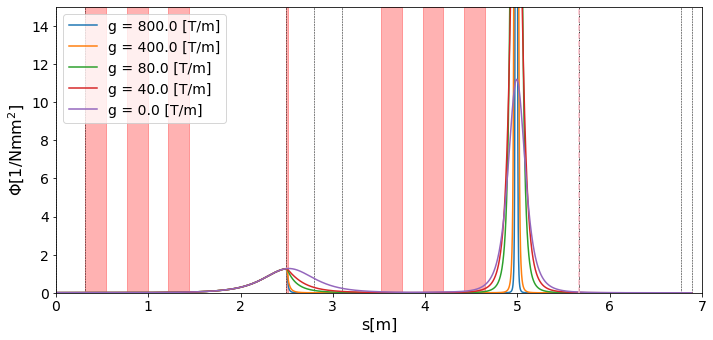

Max fluence for g = 0.0 is 28.517610918113427


In [18]:
#FLUENCE PLOTS FOR FULL LATTICE INCLUDING MATCHING SECTION
focus_dose = 17.5

# Generate several doseplots and combine them together
plasma_0_focus_sym_full = latticeplot_full(0.0, focus_dose, doPrint=False, s_star=True)[4]
#plasma_10_focus_sym_full = latticeplot_full(10.0, focus_dose, doPrint=False, s_star=True)[4]
plasma_50_focus_sym_full = latticeplot_full(50.0, focus_dose, doPrint=False, s_star=True)[4]
plasma_100_focus_sym_full = latticeplot_full(100.0, focus_dose, doPrint=False, s_star=True)[4]
plasma_500_focus_sym_full = latticeplot_full(500.0, focus_dose, doPrint=False, s_star=True)[4]
plasma_1000_focus_sym_full = latticeplot_full(1000.0,focus_dose, doPrint=False, s_star=True)[4]

plt.figure(figsize=(5.787376228033763*2, 5.787376228033763/1.1))

plt.plot(plasma_1000_focus_sym_full[0], plasma_1000_focus_sym_full[1], label=f'g = {elements.PlasmaLensUtilities.computeGradient(1000,0.50):.1f} [T/m]')#, color='gray')
plt.plot(plasma_500_focus_sym_full[0], plasma_500_focus_sym_full[1], label=f'g = {elements.PlasmaLensUtilities.computeGradient(500,0.50):.1f} [T/m]')#, color='green')
plt.plot(plasma_100_focus_sym_full[0], plasma_100_focus_sym_full[1], label=f'g = {elements.PlasmaLensUtilities.computeGradient(100,0.50):.1f} [T/m]')#, color='orange')
plt.plot(plasma_50_focus_sym_full[0], plasma_50_focus_sym_full[1], label=f'g = {elements.PlasmaLensUtilities.computeGradient(50,0.50):.1f} [T/m]')#, color='red')
plt.plot(plasma_0_focus_sym_full[0], plasma_0_focus_sym_full[1], label=f'g = {elements.PlasmaLensUtilities.computeGradient(0,0.50):.1f} [T/m]')#, color='black')
plt.axvline(x=5.667, color='pink', linestyle='dashed')
ax = plt.gca()
#plt.plot(plasma_10_focus_sym[0], plasma_10_focus_sym[1], label=f'Plasma current = {10.0} [A]')

plt.ylim([0,15])
plt.xlim([0.0,7])
plt.xlabel('s[m]', fontsize=16)
plt.ylabel(r'$\Phi$[1/Nmm$^2$]', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plot.addElemsToPlot(ax, latticeCLEAR_PLE)
#plot.addElemNamesToPlot(ax, latticeCLEAR_PLE)
#plt.xlim([2.3, 3.0])
#plt.ylim([0, 1.5])
plt.savefig(f'plots_obj3/pseudo_dose_plot_focus{focus_dose}.pdf', bbox_inches='tight')
plt.show()

#print(f'Plasma gradient for 50 A = {elements.PlasmaLensUtilities.computePlasmaK(50,0.50,P0):.1f} T/m')
print(f"Max fluence for g = 0.0 is {np.max(plasma_50_focus_sym_full)}")

### Plotting sigma for a given focus point, for all APL currents

Shape of sigmax in plasma-dim: (151, 199)
Closest value to 18.1815 is 18.1815
Closest value to 17.6815 is 17.68418181818182
Closest value to 18.6815 is 18.67854545454545


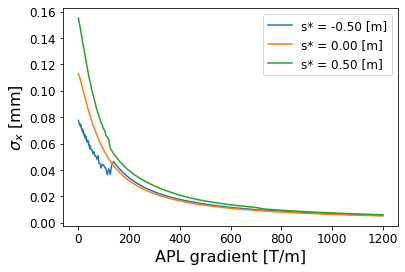

Minimum sigma_x = 0.00526863252292218
Minimum sigma_x = 0.005589306148697874
Minimum sigma_x = 0.006154448107426683


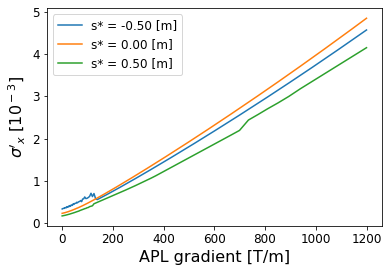

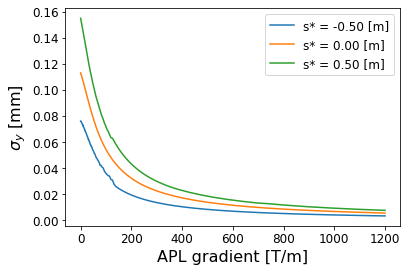

Minimum sigma_y = 0.005583511947547199
Minimum sigma_y = 0.003382545066313706
Minimum sigma_y = 0.007642998551475574


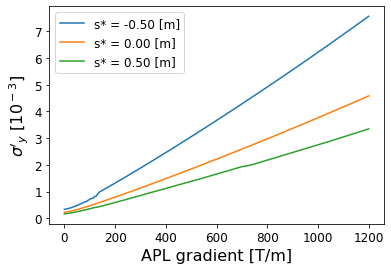

In [20]:
plasma_values = np.array([0.0] + list(np.logspace(0,np.log10(1500),150,base=10)))
total_sigmaX = np.array(sheets_data.get('list_of_sigmaX'))
total_sigmaXP = np.array(sheets_data.get('list_of_sigmaXP'))
total_sigmaY = np.array(sheets_data.get('list_of_sigmaY'))
total_sigmaYP = np.array(sheets_data.get('list_of_sigmaYP'))
s_plot = list(np.array(sheets_data.get('list_of_s')).squeeze())
TOTAL_FOCUS = list(np.array(sheets_data.get('Focus_points')).squeeze())

sigmaX_plasma_plot = []
sigmaXP_plasma_plot = []
sigmaY_plasma_plot = []
sigmaYP_plasma_plot = []
#print(total_sigmaX.shape)
find_plasma = np.linspace(0,len(plasma_values), len(plasma_values))
find_focus = np.linspace(0,199,199)
sigmaX_MAIN = []
sigmaXP_MAIN = []
sigmaY_MAIN = []
sigmaYP_MAIN = []

for j, n in enumerate(find_plasma):
    #print(j)
    for i, p in enumerate(find_focus):
        sigmax_plasma = total_sigmaX[i][j]
        sigmaxp_plasma = total_sigmaXP[i][j]
        sigmay_plasma = total_sigmaY[i][j]
        sigmayp_plasma = total_sigmaYP[i][j]
        sigmaX_plasma_plot.append(sigmax_plasma)
        sigmaXP_plasma_plot.append(sigmaxp_plasma)
        sigmaY_plasma_plot.append(sigmay_plasma)
        sigmaYP_plasma_plot.append(sigmayp_plasma)
        
    sigmaX_MAIN.append(sigmaX_plasma_plot[:])
    sigmaXP_MAIN.append(sigmaXP_plasma_plot[:])
    sigmaY_MAIN.append(sigmaY_plasma_plot[:])
    sigmaYP_MAIN.append(sigmaYP_plasma_plot[:])
    sigmaX_plasma_plot.clear()
    sigmaXP_plasma_plot.clear()
    sigmaY_plasma_plot.clear()
    sigmaYP_plasma_plot.clear()
    
plasma_sigmaX = np.array(sigmaX_MAIN)
plasma_sigmaXP = np.array(sigmaXP_MAIN)
plasma_sigmaY = np.array(sigmaY_MAIN)
plasma_sigmaYP = np.array(sigmaYP_MAIN)
print("Shape of sigmax in plasma-dim:", plasma_sigmaX.shape)

def find_focus_index(focus):
    target_focus = focus
    closest_value = min(TOTAL_FOCUS, key=lambda x: abs(x-target_focus))
    print(f'Closest value to {focus} is {closest_value}')
    index_focus = TOTAL_FOCUS.index(closest_value)
    s_value = s_plot[index_focus]
    return index_focus, s_value

focus_sym, s_sym = find_focus_index(18.1815)
focus_1750, s_1750 = find_focus_index(17.6815)
focus_1920, s_1920 = find_focus_index(18.6815)
plasma_sigmaX_plot_1 = plasma_sigmaX[:,focus_sym]
plasma_sigmaXP_plot_1 = plasma_sigmaXP[:, focus_sym]
plasma_sigmaY_plot_1 = plasma_sigmaY[:,focus_sym]
plasma_sigmaYP_plot_1 = plasma_sigmaYP[:,focus_sym]
plasma_sigmaX_plot_2 = plasma_sigmaX[:,focus_1750]
plasma_sigmaXP_plot_2 = plasma_sigmaXP[:,focus_1750]
plasma_sigmaY_plot_2 = plasma_sigmaY[:,focus_1750]
plasma_sigmaYP_plot_2 = plasma_sigmaYP[:,focus_1750]
plasma_sigmaX_plot_3 = plasma_sigmaX[:,focus_1920]
plasma_sigmaXP_plot_3 = plasma_sigmaXP[:,focus_1920]
plasma_sigmaY_plot_3 = plasma_sigmaY[:,focus_1920]
plasma_sigmaYP_plot_3 = plasma_sigmaYP[:,focus_1920]

gk = elements.PlasmaLensUtilities.computeGradient(plasma_values,0.50)

plt.figure()

plt.plot(gk, plasma_sigmaX_plot_2, label=f's* = {s_1750:.2f} [m]')
plt.plot(gk, plasma_sigmaX_plot_1, label=f's* = {s_sym:.2f} [m]')
plt.plot(gk, plasma_sigmaX_plot_3, label=f's* = {s_1920:.2f} [m]')
plt.xlabel(f'APL gradient [T/m]', fontsize=16)
plt.ylabel(f'$\sigma_x$ [mm]', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig(f'plots_obj2/sigmax_vs_plasma.pdf', bbox_inches='tight')
plt.show()

print(f'Minimum sigma_x = {np.min(plasma_sigmaX_plot_1)}')
print(f'Minimum sigma_x = {np.min(plasma_sigmaX_plot_2)}')
print(f'Minimum sigma_x = {np.min(plasma_sigmaX_plot_3)}')


plt.plot(gk, plasma_sigmaXP_plot_2, label=f's* = {s_1750:.2f} [m]')
plt.plot(gk, plasma_sigmaXP_plot_1, label=f's* = {s_sym:.2f} [m]')
plt.plot(gk, plasma_sigmaXP_plot_3, label=f's* = {s_1920:.2f} [m]')
plt.xlabel(f'APL gradient [T/m]', fontsize=16)
plt.ylabel(f"$\sigma'_x$ [10$^-$$^3$]", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig(f'plots_obj2/sigmaxp_vs_plasma.pdf', bbox_inches='tight')
plt.show()

plt.figure()

plt.plot(gk, plasma_sigmaY_plot_2, label=f's* = {s_1750:.2f} [m]')
plt.plot(gk, plasma_sigmaY_plot_1, label=f's* = {s_sym:.2f} [m]')
plt.plot(gk, plasma_sigmaY_plot_3, label=f's* = {s_1920:.2f} [m]')
plt.xlabel(f'APL gradient [T/m]', fontsize=16)
plt.ylabel(f'$\sigma_y$ [mm]', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig(f'plots_obj2/sigmay_vs_plasma.pdf', bbox_inches='tight')
plt.show()

print(f'Minimum sigma_y = {np.min(plasma_sigmaY_plot_1)}')
print(f'Minimum sigma_y = {np.min(plasma_sigmaY_plot_2)}')
print(f'Minimum sigma_y = {np.min(plasma_sigmaY_plot_3)}')

plt.figure()

plt.plot(gk, plasma_sigmaYP_plot_2, label=f's* = {s_1750:.2f} [m]')
plt.plot(gk, plasma_sigmaYP_plot_1, label=f's* = {s_sym:.2f} [m]')
plt.plot(gk, plasma_sigmaYP_plot_3, label=f's* = {s_1920:.2f} [m]')
plt.xlabel(f'APL gradient [T/m]', fontsize=16)
plt.ylabel(f"$\sigma'_y$ [10$^-$$^3$]", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig(f'plots_obj2/sigmayp_vs_plasma.pdf', bbox_inches='tight')
plt.show()



